In [258]:
# Imports
import pandas as pd
import numpy as np

# ----------- Statistics -------------------- #
from scipy.stats import spearmanr
# Tests
from scipy.stats import chi2_contingency

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [202]:
# Functions
# ----------------------- Function for hypothesis testing ---------------------------------- #
def hypothesis_testing(p_value, alpha=0.05):
    ''' 
Prints decision to reject/accept null hypothesis given a significance level and the p-value of the statistical test
    '''
    if p_value < alpha:
        print(f'Given p value = {p_value} is smaller than alpha = {alpha}, the null hypothesis is rejected.')
    else:
        print(f'Given p value = {p_value} is greater than alpha = {alpha}, the null hypothesis fails to be rejected.')

def bootstrapping(data, num_samples):
    '''
    Takes array, number of iterations (means to compute) and returns 95% CI of the mean
    Arguments:
        - Data: np.array
        - CI, number iter
    '''
    bootstrap_means = np.zeros(num_samples)
    for idx_iter in range(num_samples):
        # Sampling from sample
        bootstrap_means[idx_iter] = np.random.choice(data, size=data.size, replace=True).mean()
    
    # np.percentile: computes percentile of data without need to sort
    low_bound = np.percentile(bootstrap_means, 2.5)
    upper_bound = np.percentile(bootstrap_means, 97.5)
    return (low_bound, upper_bound)


def replace_category(df, target_category, new_category):
    # Find articles with the target category
    articles_to_modify = df[df['category1'] == target_category]['article'].unique()

    # Create a DataFrame to hold modified entries with the new category
    modified_entries = pd.DataFrame({
        'article': articles_to_modify,
        'category1': new_category
    })

    # Remove all instances of these articles from the original DataFrame
    df_modified = df[~df['article'].isin(modified_entries['article'])]

    # Add the modified entries back to the DataFrame
    df_result = pd.concat([df_modified, modified_entries]).reset_index(drop=True)

    return df_result


In [99]:
# Load TSV file for'paths_unfinished' and 'paths_finished' into a DataFrame
unfinished_paths_column_names = ["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"]
df_unfinished = pd.read_csv('./dataset/paths_unfinished.tsv',
                             names= unfinished_paths_column_names, sep='\t',
                             comment='#') #ignore metadata

# Add 'source' column for unfinished paths
df_unfinished['source'] = df_unfinished['path'].str.split(';').str[0]
# Add 'quitting_article' column for article at which game was quitted
# regex=True allows str.split() to usel split on any of those two delimiters 
# Need to include < for backtracking
df_unfinished['quitting_article'] = df_unfinished['path'].str.split('[;,<]', regex=True).str[-1]


finished_paths_column_names = ["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"]
# NULL in 'rating' -> NaN
df_finished = pd.read_csv('./dataset/paths_finished.tsv',
                             names= finished_paths_column_names, sep='\t',
                             comment='#') #ignore metadata

# Add 'source' and 'target' columns for finished paths
df_finished['source'] = df_finished['path'].str.split(';').str[0]
df_finished['target'] = df_finished['path'].str.split('[;,<]', regex=True).str[-1]


In [44]:
df_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type,source,article_quit
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,Obi-Wan_Kenobi,Obi-Wan_Kenobi
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,Julius_Caesar,Julius_Caesar
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,Malawi,Alexander_the_Great
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,Paraguay,Paraguay
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,Paraguay,Bolivia


In [100]:
df_finished.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,source,target
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,14th_century,African_slave_trade
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,14th_century,African_slave_trade
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,14th_century,African_slave_trade
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,14th_century,Greece
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,14th_century,John_F._Kennedy


### Correlations between quitting behaviour and features

The column `type` describes the reason for quitting:
- `timeout`: no click made for 30 minutes.
- `restart`: user started a new game without finishing the current one.

**Analysis will focus on "restart"-type quitting**

- `restart`quitting indicates that the user actively decided to start a new game, while `timeout` quitting could occur due to distractions, leaving the game open, or internet issues; hence, it is less indicative of a user’s decision to quit.

In [27]:
# Filter dataset according to restart behaviour

#df_unfinished_t = df_unfinished[df_unfinished['type']=='timeout']
#df_unfinished_r = df_unfinished[df_unfinished['type']=='restart']
# df_unfinished.head()

**Correlation with time at which game began**

In [28]:
# 'Convert Unix timestamps to readable format
df_unfinished['datetime'] = pd.to_datetime(df_unfinished['timestamp'], unit='s')
df_finished['datetime'] = pd.to_datetime(df_finished['timestamp'], unit='s')
# Extract hour
df_unfinished['hour'] = df_unfinished['datetime'].dt.hour
df_finished['hour'] = df_finished['datetime'].dt.hour

In [29]:
# Total games per hour
total_games_per_hour = df_unfinished['hour'].value_counts() + df_finished['hour'].value_counts()

# Proportion of unfinished games by hour
unfinished_counts = df_unfinished['hour'].value_counts()
proportion_unfinished = (unfinished_counts / total_games_per_hour).fillna(0)

# Proportion of finished games by hour
finished_counts = df_finished['hour'].value_counts()
proportion_finished = (finished_counts / total_games_per_hour).fillna(0)

In [30]:
# Prepare data for bootstrapping by creating binary arrays
ci_results = {'hour': [], 'proportion_unfinished': [], 'ci_lower_unfinished': [], 'ci_upper_unfinished': [],
              'proportion_finished': [], 'ci_lower_finished': [], 'ci_upper_finished': []}

for hour in sorted(total_games_per_hour.index):
    # Create binary arrays: 1 if unfinished or finished, 0 otherwise
    unfinished_data = np.array([1] * unfinished_counts.get(hour, 0) + [0] * (total_games_per_hour[hour] - unfinished_counts.get(hour, 0)))
    finished_data = np.array([1] * finished_counts.get(hour, 0) + [0] * (total_games_per_hour[hour] - finished_counts.get(hour, 0)))

    # Calculate observed proportions
    prop_unfinished = unfinished_counts.get(hour, 0) / total_games_per_hour[hour]
    prop_finished = finished_counts.get(hour, 0) / total_games_per_hour[hour]

    # Bootstrap CI
    ci_unfinished = bootstrapping(unfinished_data, num_samples=1000)
    ci_finished = bootstrapping(finished_data, num_samples=1000)

    # Store the results
    ci_results['hour'].append(hour)
    ci_results['proportion_unfinished'].append(prop_unfinished)
    ci_results['ci_lower_unfinished'].append(ci_unfinished[0])
    ci_results['ci_upper_unfinished'].append(ci_unfinished[1])
    ci_results['proportion_finished'].append(prop_finished)
    ci_results['ci_lower_finished'].append(ci_finished[0])
    ci_results['ci_upper_finished'].append(ci_finished[1])

# Convert results to DataFrame for easy plotting
ci_df = pd.DataFrame(ci_results)

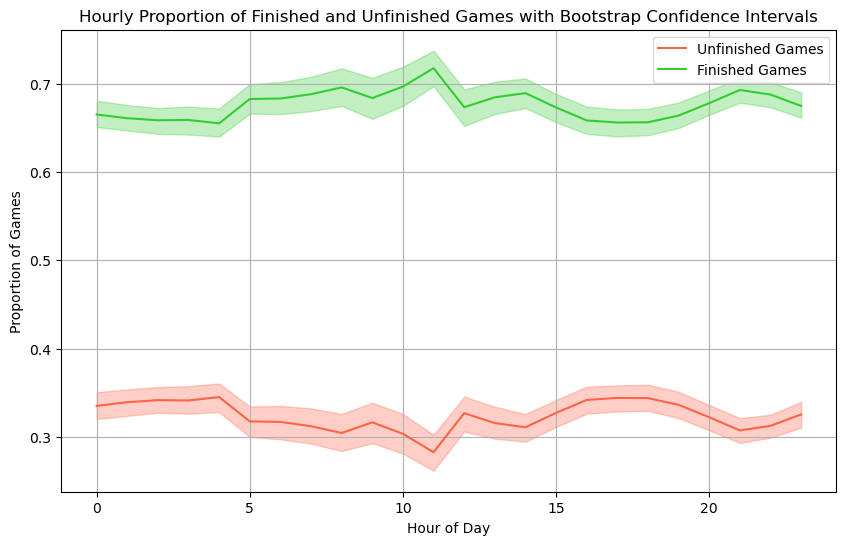

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot proportions for unfinished games
ax.plot(ci_df['hour'], ci_df['proportion_unfinished'], color='tomato', label='Unfinished Games')
# Shaded area for the confidence interval of unfinished games
ax.fill_between(ci_df['hour'], ci_df['ci_lower_unfinished'], ci_df['ci_upper_unfinished'], 
                color='tomato', alpha=0.3)

# Plot proportions for finished games
ax.plot(ci_df['hour'], ci_df['proportion_finished'], color='limegreen', label='Finished Games')
# Shaded area for the confidence interval of finished games
ax.fill_between(ci_df['hour'], ci_df['ci_lower_finished'], ci_df['ci_upper_finished'], 
                color='limegreen', alpha=0.3)

# Labels and title
ax.set_title('Hourly Proportion of Finished and Unfinished Games with Bootstrap Confidence Intervals')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Proportion of Games')
ax.legend()
plt.grid(True)
plt.show()

In [32]:
df_unfinished_t = df_unfinished[df_unfinished['type']=='timeout']
df_unfinished_r = df_unfinished[df_unfinished['type']=='restart']

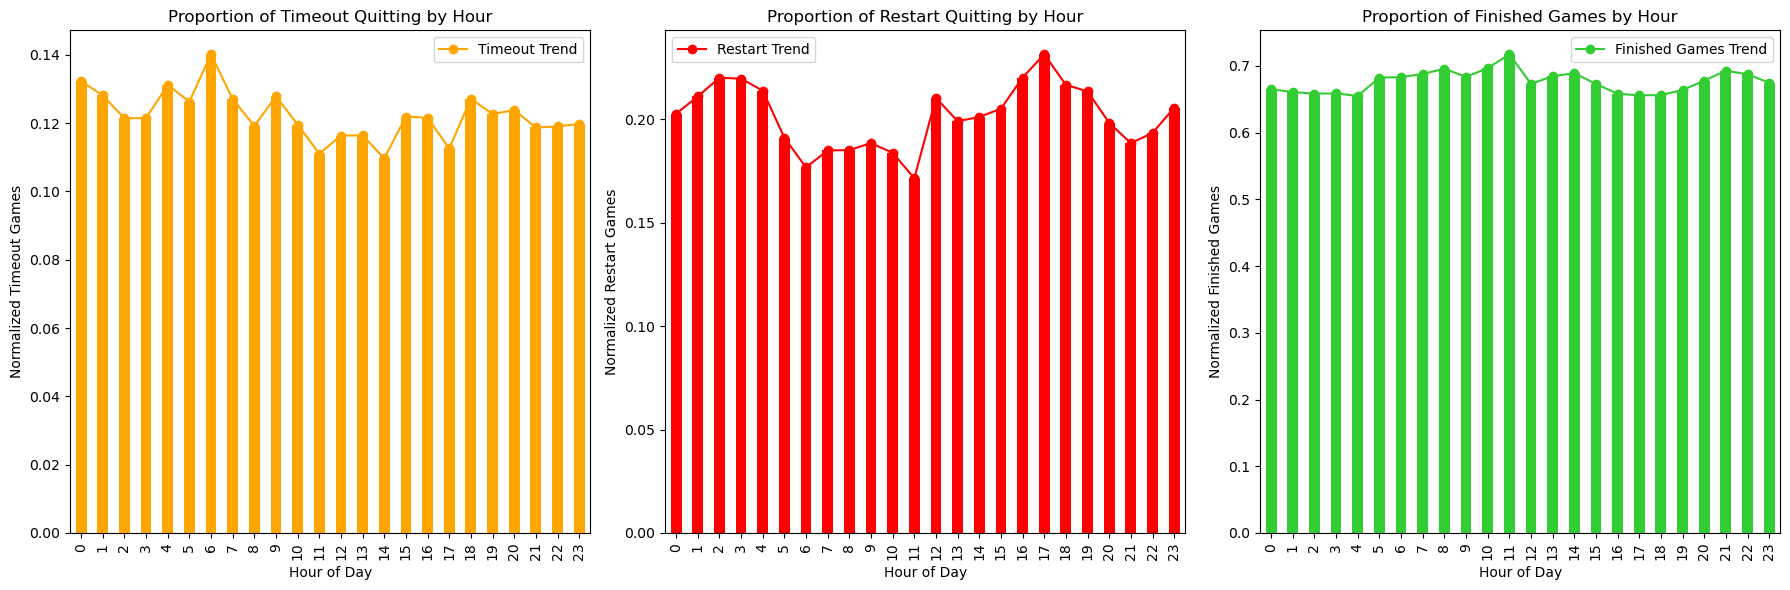

In [ ]:
# Plotting
'''
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18, 6))

# Plot normalized unfinished games (timeout) per hour
df_unfinished_t_hour_norm.plot(kind='bar', color='orange', ax=ax0)
ax0.set_title('Proportion of Timeout Quitting by Hour')
ax0.set_xlabel('Hour of Day')
ax0.set_ylabel('Normalized Timeout Games')
ax0.plot(df_unfinished_t_hour_norm, color='orange', marker='o', linestyle='-', label='Timeout Trend')
ax0.legend()

# Plot normalized unfinished games (restart) per hour
df_unfinished_r_hour_norm.plot(kind='bar', color='red', ax=ax1)
ax1.set_title('Proportion of Restart Quitting by Hour')
ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Normalized Restart Games')
ax1.plot(df_unfinished_r_hour_norm, color='red', marker='o', linestyle='-', label='Restart Trend')
ax1.legend()

# Plot normalized finished games per hour
df_finished_hour_norm.plot(kind='bar', color='limegreen', ax=ax2)
ax2.set_title('Proportion of Finished Games by Hour')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('Normalized Finished Games')
ax2.plot(df_finished_hour_norm, color='limegreen', marker='o', linestyle='-', label='Finished Games Trend')
ax2.legend()

# Adjust layout
plt.tight_layout()
plt.show()
'''

There appears to be no strong correlation between the hour of day and the proportion of unfinished games. Both finished and unfinished games seem relatively stable throughout the day, displaying very small fluctutations that do not follow any meaningful pattern.

**Compare game time duration**

- Finished vs unfinished -> Do people quit because they are spending on average more that time that they should?
- Feature: 'durationinSec'

In [304]:
df_finished['min'] = df_finished['durationInSec']/60
df_unfinished['min'] = df_unfinished['durationInSec']/60

10855    584.850000
49073    566.816667
23509    388.766667
23023    329.000000
43583    286.183333
22461    260.916667
46572    177.833333
33848    169.650000
46892    161.400000
9955     153.083333
Name: min, dtype: float64


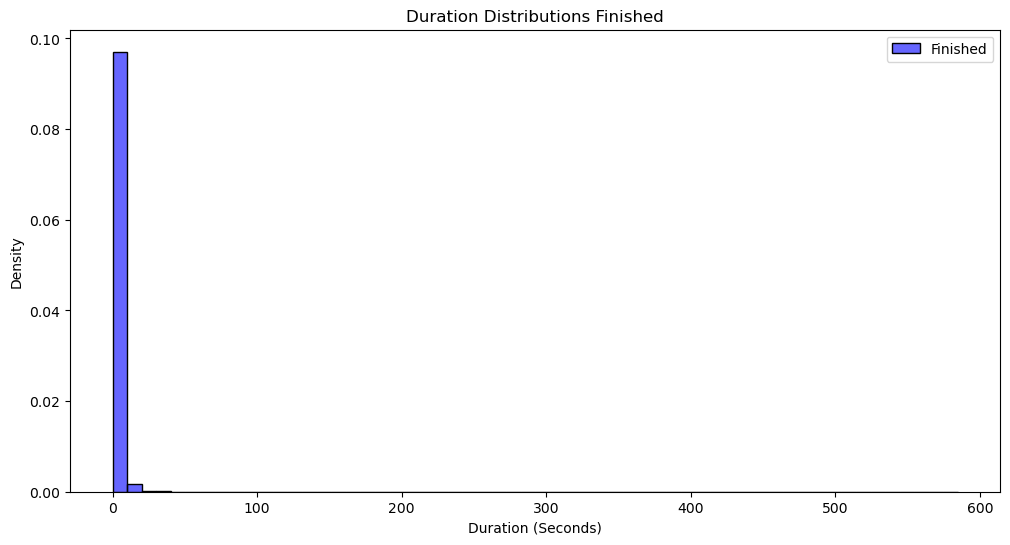

In [305]:


plt.figure(figsize=(12, 6))

top_durations = df_finished['min'].sort_values(ascending=False).head(10)
print(top_durations)

# Histogram for finished durations
sns.histplot(df_finished['min'], color='blue', label='Finished', kde=False, stat="density", binwidth=10, alpha=0.6)

# Labels and title
plt.xlabel("Duration (Seconds)")
plt.ylabel("Density")
plt.title("Duration Distributions Finished")
plt.legend()
plt.show()

In [ ]:
# Descriptive statistics for unfinished durations
unfinished_stats = df_unfinished['min'].describe()
unfinished_skewness = df_unfinished['min'].skew()

# Descriptive statistics for finished durations
finished_stats = df_finished['min'].describe()
finished_skewness = df_finished['min'].skew()

# Display results
print("Unfinished Duration Distribution:")
print(unfinished_stats)
print(f"Skewness: {unfinished_skewness}\n")

print("Finished Duration Distribution:")
print(finished_stats)
print(f"Skewness: {finished_skewness}")

Unfinished Duration Distribution:
count    24875.000000
mean        13.921615
std         14.688133
min          0.066667
25%          1.433333
50%          4.350000
75%         30.516667
max        151.483333
Name: min, dtype: float64
Skewness: 0.5905567996278934

Finished Duration Distribution:
count    51318.000000
mean         2.637937
std          6.014032
min          0.000000
25%          1.000000
50%          1.783333
75%          3.050000
max        584.850000
Name: min, dtype: float64
Skewness: 50.00426635134796


**Correlation with thematic**

In [ ]:
# Accessing categories
categories_column_names = ['article','category']
df_categories = pd.read_csv('./dataset/categories.tsv',
                             sep='\t',
                             names = categories_column_names,
                             comment='#') #ignore metadata
# Eliminate subject. from field 'category'
df_categories['category'] = df_categories['category'].str.replace('subject.', '', regex=True)


# Add entries for missing articles and category pairs (examples) -> Remaining just eliminated
#df_categories.loc[len(df_categories)] = ['Pikachu', 'Everyday_life.Games']
#df_categories.loc[len(df_categories)] = ['Adolph_Hitler', 'People.Political_People']
# For now, will eliminate remaining


# Create from 'category' two columns; ' category1' for main category ; 'category2' for secondary category
df_categories['category1'] = df_categories['category'].str.split('.').str[0]
# Apply lambda function to check whether category is hierarchical or just one identifier
#No need to add .str: lambda function splits each string independently, so x in the function represents a single string, not the entire Series.
df_categories['category2'] = df_categories['category'].apply(lambda x: x.split('.')[1] if len(x.split('.')) > 1 else x.split('.')[0])
# Drop 'category' column
df_categories = df_categories.drop('category', axis=1)



# Number of categories
num_categories = df_categories['category1'].nunique()
print("Number of main categories:", num_categories)
num_categories = df_categories['category2'].nunique()
print("Number of secondary categories:", num_categories)




Number of main categories: 15
Number of secondary categories: 103


In [277]:
people_categories = df_categories[df_categories['category1'] == 'People']['category2'].unique()

# Print the unique category2 values
print("Unique category2 values for 'People':")
for category in people_categories:
    print(category)

Unique category2 values for 'People':
Historical_figures
Artists
Sports_and_games_people
Geographers_and_explorers
Writers_and_critics
USA_Presidents
Religious_figures_and_leaders
Political_People
Producers_directors_and_media_figures
Mathematicians
Astronomers_and_physicists
Engineers_and_inventors
Military_People
Chemists
Monarchs_of_Great_Britain
Actors_models_and_celebrities
Performers_and_composers
Philosophers
Human_Scientists
Computing_People


In [278]:
# DUPLICATED ENTRIES

# Check for duplicate articles
duplicate_articles = df_categories[df_categories['article'].duplicated()]
print("Duplicate articles:")
print(len(duplicate_articles))

# 1. Countries -> 2 categories ('Countries', 'Geography')
# Discard 'Geography' category, retain 'Countries'
df_categories = replace_category(df=df_categories, target_category='Countries', new_category='Countries')


# Article with 2 different 'People' entries -> New classification (more meaningful; according to own criteria)

duplicated_people_category2 = {
    'Benjamin_of_Tudela': 'Geographers_and_explorers',  # History
    'King_Arthur': 'Historical_figures',  # History
    'Laika': 'Astronomers_and_physicists',  # Science 
    'Alfred_the_Great': 'Monarchs_of_Great_Britain',  # History
    'Attila_the_Hun': 'Historical_figures',  # History
    'Benjamin_Franklin': 'Human_Scientists',  # History 
    'Boyle_Roche': 'Political_People',  # History
    'Edward_the_Confessor': 'Monarchs_of_Great_Britain',  # History
    'Galileo_Galilei': 'Astronomers_and_physicists',  # Science
    'James_Garfield': 'USA_Presidents',  # History
    'James_Watt': 'Engineers_and_inventors',  # Science
    'Leonardo_da_Vinci': 'Artists',  # Art 
    'Nikola_Tesla': 'Engineers_and_inventors',  # Science
    'Oliver_Cromwell': 'Political_People',  # History
    'Ulysses_S._Grant': 'USA_Presidents',  # History
    'William_Ewart_Gladstone': 'Political_People'  # History
}

# Select articles corresponding to above historical figures and with People entry
df_relevant = df_categories[
    (df_categories['article'].isin(duplicated_people_category2.keys())) &
    (df_categories['category1'] == 'People')
].drop_duplicates(subset='article') # Arbitrary elimination, since new classification will be done accordint to own criteria
# Replace 'category2' by new classification
df_relevant['category2'] = df_relevant['article'].map(duplicated_people_category2)
# In original df, eliminate those article entries and add new ones
df_categories = df_categories[~df_categories['article'].isin(df_relevant['article'])]
# Concatenate with entires with new 'category2'
df_categories = pd.concat([df_categories, df_relevant]).reset_index(drop=True)


# Define a mapping dictionary for category2 to category1
category2_to_category1 = {
    'Historical_figures': 'History',
    'Monarchs_of_Great_Britain': 'History',
    'Military_People': 'History', # Otherwise: Citizenship -> Connected to Politics
    'Mathematicians': 'Mathematics',
    'Astronomers_and_physicists': 'Science',
    'Chemists': 'Science',
    'Engineers_and_inventors': 'Science',
    'Computing_People': 'Science',
    'Human_Scientists': 'History',
    'Artists': 'Art',
    'Writers_and_critics': 'Language_and_literature',
    'Producers_directors_and_media_figures': 'People',
    'Performers_and_composers': 'Music',
    'Actors_models_and_celebrities': 'People',
    'USA_Presidents': 'History',
    'Political_People': 'History',
    'Religious_figures_and_leaders': 'History',
    'Geographers_and_explorers': 'History',
    'Sports_and_games_people': 'People',
    'Philosophers': 'History'
}


# Filter the DataFrame in one step to retain only articles with relevant 'category2' values and 'category1' as "People"
df_relevant = df_categories[
    (df_categories['category2'].isin(category2_to_category1.keys())) &
    (df_categories['category1'] == 'People')
]


modified_entries_df = pd.DataFrame({
        'article': df_relevant['article'],
        'category1': df_relevant['category1'],
        'category2': df_relevant['category2']
    })

# Map `category2` to `category1` for relevant entries
modified_entries_df['category1'] = modified_entries_df['category2'].map(category2_to_category1).combine_first(modified_entries_df['category1'])
# Remove all corresponding articles from dataset
df_categories = df_categories[~df_categories['article'].isin(modified_entries_df['article'])]
# Step 6: Concatenate back the cleaned and relevant data
df_categories = pd.concat([df_categories, modified_entries_df]).reset_index(drop=True)


#  Historical figures -> 2 Categories ('People', 'History')
# Maintain History -> Prioritize the History category over People (historical focus of figure)
#df_categories = replace_category(df=df_categories, target_category='People.Historical_figures', new_category='History')

# (Some) musicians -> 2 categories ('Music') or ('People.Performers_and_composers)
#df_categories = replace_category(df=df_categories, target_category='People.Performers_and_composers', new_category='Music')

# ...


# Duplicates for not 'People' entries according to category hierarchy


# Define the hierarchy for `category1`
category_hierarchy = {
    'Everyday_life': 1,
    'Language_and_literature': 2,
    'Music': 3,
    'History': 4,
    'Art': 5,
    'Mathematics': 6,
    'Science': 7,
     'IT': 8,
     'Design_and_Technology': 9,
    'Business_Studies': 10,
    'Geography': 11,
    'Religion': 12,
    'Citizenship': 13,
    'Countries': 14
}

# Add a `rank` column based on the hierarchy
df_categories['rank'] = df_categories['category1'].map(category_hierarchy)

# Sort by article and rank, then drop duplicates by keeping the highest priority category for each article
# If some articles have duplicated 'category1' and different 'category2'
# Ordered from lowest to highest rank-> First, paired alphabetically and then by rank ; and keep only first entry; then drop rank
df_categories= df_categories.sort_values(by=['article', 'rank']).drop_duplicates(subset='article', keep='first').drop(columns=['rank']).reset_index(drop=True)


Duplicate articles:
606


In [279]:

df_categories[df_categories['article']== 'Leonardo_da_Vinci']

,article,category1,category2
2444,Leonardo_da_Vinci,Art,Artists


In [280]:
duplicate_articles = df_categories[df_categories['article'].duplicated()]
print("Duplicate articles:")
print(len(duplicate_articles))
print(list(duplicate_articles['article']))

# Some figures have two 'People' entries
# Ex: Nikola Tesla ('engineer and inventor; and physicist)
# Change first these so only one remaining 'People' category



Duplicate articles:
0
[]



About duplicate:

**Rules**
- Establish hierarchy based on seen examples of duplicated entries:
- Hierarchy: 'Everyday_life' > 'Language_and_literature' > ...> 'History' > ..>'Science'> ...> 'IT'>' ....
- Many duplications with same 'category1' -> Keep  randomly any of the 'category2'






- Duplicate: 'Language_and_literature' and 'History' -> Keep 'Language_and_literature' (more relevant)
- Duplicate: any category and 'History' -> Keep 'History' (more relevant)
- If both in 'Everyday_life' and other category: maintain 'Everyday_life' (more relevant)

-  Between 'Design_and_technology' and 'Science' -> keep 'Design_and_technology'
- Between 'Citizenship' and any other -> keep any other
- Between 'IT' and 'Science' keep -> 'Science'
- Abacus: Abacus	subject.Everyday_life.Everyday_life
Abacus	subject.Mathematics
- Abbey	subject.History.British_History.British_History_15001750
Abbey	subject.Religion.Religious_movements_traditions_and_organizations
- Abbot	subject.History.British_History.British_History_15001750
Abbot	subject.Religion.Religious_movements_traditions_and_organizations
- Acid_rain	subject.Citizenship.Environment
Acid_rain	subject.Geography.General_Geography
- Acorn_Computers	subject.Business_Studies.Companies
Acorn_Computers	subject.IT.Computing_hardware_and_infrastructure
Advertising	subject.Business_Studies.Business
Advertising	subject.Everyday_life.Everyday_life
Al_Jazeera	subject.Citizenship.Media
Al_Jazeera	subject.Citizenship.Politics_and_government
Albigensian_Crusade	subject.History.Pre_1900_Military
Albigensian_Crusade	subject.Religion.Religious_disputes
Almond	subject.Everyday_life.Food_and_agriculture
Almond	subject.Science.Biology.Plants
Anglo-Saxon_literature	subject.History.British_History.British_History_1500_and_before_including_Roman_Britain
Anglo-Saxon_literature	subject.Language_and_literature.Literature_types
Animation	subject.Everyday_life.Computer_and_Video_games
Animation	subject.Everyday_life.Films
Anschluss	subject.History.Recent_History
Anschluss	subject.History.World_War_II
Aquarium	subject.Everyday_life.Everyday_life
Aquarium	subject.Science.Biology.General_Biology
Avocado	subject.Everyday_life.Food_and_agriculture
Avocado	subject.Science.Biology.Plants
Avro_Lancaster	subject.Design_and_Technology.Air_and_Sea_transport
Avro_Lancaster	subject.History.World_War_II
BBC	subject.Citizenship.Media
BBC	subject.Everyday_life.Television
Bede	subject.History.British_History.British_History_1500_and_before_including_Roman_Britain
Bede	subject.History.Historians_chroniclers_and_history_books
Beekeeping	subject.Everyday_life.Food_and_agriculture
Beekeeping	subject.Everyday_life.Recreation
Beer	subject.Everyday_life.Drink
Beet	subject.Everyday_life.Food_and_agriculture
Biodiesel	subject.Design_and_Technology.Engineering
Biodiesel	subject.Citizenship.Environment
Biodiversity	subject.Citizenship.Environment
Biodiversity	subject.Science.Biology.General_Biology
Bioinformatics	subject.Science.Biology.General_Biology
Bioinformatics	subject.IT.SoftwareBioinformatics	subject.Science.Biology.General_Biology
Bluetooth	subject.Science.Physics.Electricity_and_Electronics
Bluetooth	subject.Design_and_Technology.Engineering
Bodyline	subject.History.British_History.British_History_Post_1900
Bodyline	subject.Everyday_life.Sports_events
British_East_India_Company	subject.History.British_History.British_History_15001750
British_East_India_Company	subject.Business_Studies.Companies

In [281]:
duplicate_articles = df_categories[df_categories['article'].duplicated(keep=False)]
print("Duplicate articles:")
print(len(duplicate_articles))
print(duplicate_articles)

Duplicate articles:
0
Empty DataFrame
Columns: [article, category1, category2]
Index: []


In [282]:
# Creation of series corresponding to category of source, target and "quitting" article for unfinished

#  Obtain main category for 'source' articles
source_categories = df_unfinished.merge(
    df_categories[['article', 'category1']], 
    left_on='source', # source column in df_unfinished as the key for merging
    right_on='article',  # article column in df_categories as the key for merging
    how='left' # Keeps all rows from df_unfinished, adding category information where available; otherwise NaN
)['category1'].rename('source_category') # select only category1 and rename it
# No NaNs for sources after adding entry for 'Pikachu'
source_categories_unf = source_categories.dropna()
source_categories_unf = source_categories_unf.value_counts()

#  Obtain main category for 'target' articles
target_categories = df_unfinished.merge(
    df_categories[['article', 'category1']], 
    left_on='target', # source column in df_unfinished as the key for merging
    right_on='article',  # article column in df_categories as the key for merging
    how='left' # Keeps all rows from df_unfinished, adding category information where available; otherwise NaN
)['category1'].rename('target_category') # select only category1 and rename it

# len(target_categories): 29185 target articles -> 27 NaNs -> 27 articles dont have corresponding category
# Remove rows with NaN values in target_category
target_categories_unf = target_categories.dropna()
target_categories_unf = target_categories_unf.value_counts()


#  Obtain main category for 'quitting_article' articles
quitting_categories = df_unfinished.merge(
    df_categories[['article', 'category1']], 
    left_on='quitting_article', # source column in df_unfinished as the key for merging
    right_on='article',  # article column in df_categories as the key for merging
    how='left' # Keeps all rows from df_unfinished, adding category information where available; otherwise NaN
)['category1'].rename('quitting_category') # select only category1 and rename it
# len(quitting_categories): 30351 -> 2221 NaNs -> 2221 articles dont have category
quitting_categories = quitting_categories.dropna()
quitting_categories = quitting_categories.value_counts()

In [283]:
# Creation of series corresponding to category of source, target and "quitting" article for finished
#  Obtain main category for 'source' articles
source_categories = df_finished.merge(
    df_categories[['article', 'category1']], 
    left_on='source', # source column in df_unfinished as the key for merging
    right_on='article',  # article column in df_categories as the key for merging
    how='left' # Keeps all rows from df_unfinished, adding category information where available; otherwise NaN
)['category1'].rename('source_category') # select only category1 and rename it
source_categories_f = source_categories.dropna()
source_categories_f = source_categories_f.value_counts()

#  Obtain main category for 'target' articles
target_categories = df_finished.merge(
    df_categories[['article', 'category1']], 
    left_on='target', # source column in df_unfinished as the key for merging
    right_on='article',  # article column in df_categories as the key for merging
    how='left' # Keeps all rows from df_unfinished, adding category information where available; otherwise NaN
)['category1'].rename('target_category') # select only category1 and rename it

target_categories_f = target_categories.dropna()
target_categories_f = target_categories_f.value_counts()

In [284]:
# Total source and target
target_categories_total_count = target_categories_f + target_categories_unf
source_categories_total_count = source_categories_f + source_categories_unf
# Normalize unfinished path category count by total number
target_categories_unf_norm = target_categories_unf/target_categories_total_count
source_categories_unf_norm =  source_categories_unf/source_categories_total_count
# Normalize quitting categories using target categories for finished games
quitting_categories_norm = quitting_categories/(quitting_categories+target_categories_f)

In [285]:
# Rank each category in each Series
target_rank = target_categories_unf_norm.rank(ascending=False)
source_rank = source_categories_unf_norm.rank(ascending=False)
quitting_rank = quitting_categories_norm.rank(ascending=False)

rankings_df = pd.DataFrame({
    'Target Rank': target_rank,
    'Source Rank': source_rank,
    'Quitting Rank': quitting_rank
})

# Calculate average rank across target, source, and quitting categories
rankings_df['Average Rank'] = rankings_df.mean(axis=1)

# Sort by average rank to find consistently high and low categories
rankings_df_sorted = rankings_df.sort_values(by='Average Rank')
print("Top consistently ranked categories:")
print(rankings_df_sorted.head())  # Top categories

print("\nLowest consistently ranked categories:")
print(rankings_df_sorted.tail())  # Bottom categories

Top consistently ranked categories:
                         Target Rank  Source Rank  Quitting Rank  Average Rank
Language_and_literature          4.0          2.0            2.0      2.666667
Design_and_Technology            3.0          1.0           14.0      6.000000
Art                              8.0          3.0            8.0      6.333333
Citizenship                      7.0         10.0            3.0      6.666667
Business_Studies                 5.0         12.0            4.0      7.000000

Lowest consistently ranked categories:
             Target Rank  Source Rank  Quitting Rank  Average Rank
People               1.0         11.0           15.0      9.000000
History             11.0          9.0           11.0     10.333333
Music                6.0         13.0           12.0     10.333333
Mathematics         12.0          8.0           13.0     11.000000
Geography           14.0         14.0            7.0     11.666667


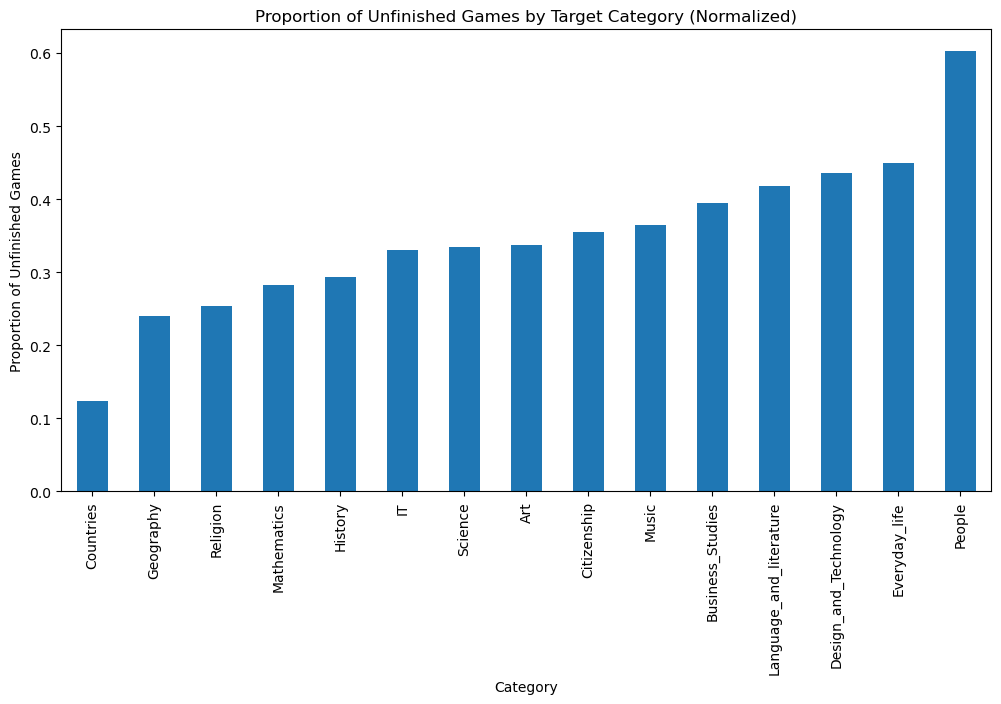

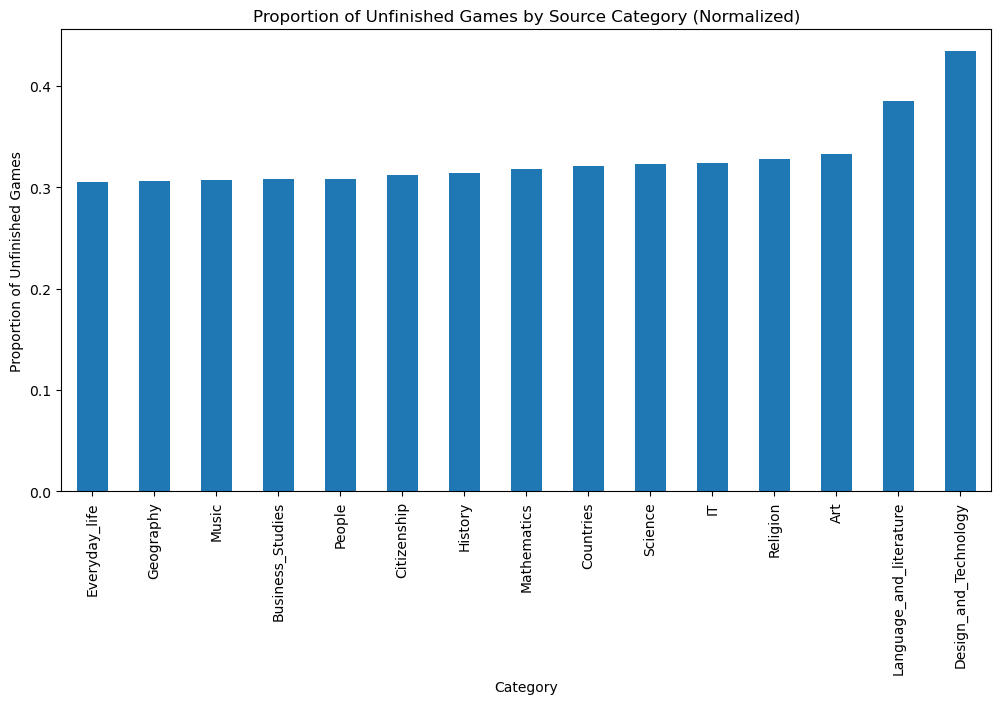

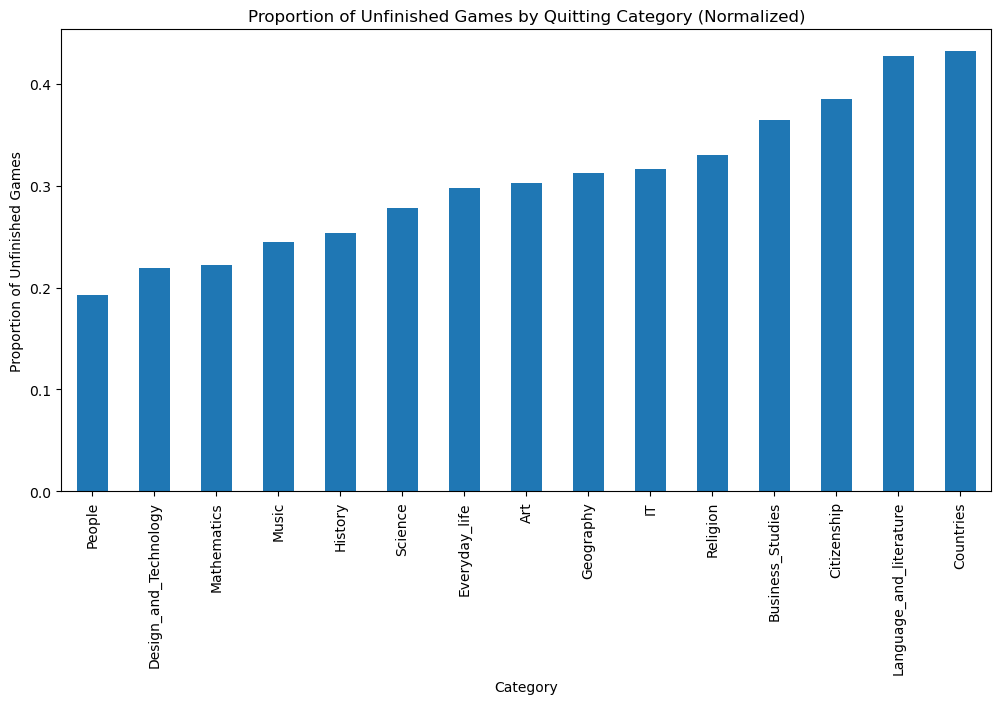

In [286]:
# Bar plot for target categories
target_categories_unf_norm.sort_values().plot(kind='bar', figsize=(12, 6))
plt.title("Proportion of Unfinished Games by Target Category (Normalized)")
plt.xlabel("Category")
plt.ylabel("Proportion of Unfinished Games")
plt.show()

# Bar plot for source categories
source_categories_unf_norm.sort_values().plot(kind='bar', figsize=(12, 6))
plt.title("Proportion of Unfinished Games by Source Category (Normalized)")
plt.xlabel("Category")
plt.ylabel("Proportion of Unfinished Games")
plt.show()

# Bar plot for quitting categories
quitting_categories_norm.sort_values().plot(kind='bar', figsize=(12, 6))
plt.title("Proportion of Unfinished Games by Quitting Category (Normalized)")
plt.xlabel("Category")
plt.ylabel("Proportion of Unfinished Games")
plt.show()

In [287]:
# Analyzing difficulty of category by rating (difficulty)

# Add target categories to finished paths
df_finished_categories = df_finished.merge(
    df_categories[['article', 'category1']], 
    left_on='target', 
    right_on='article',
    how='left'
).rename(columns={'category1': 'target_category'}).drop(columns='article')

# Merge again to add source_category
df_finished_categories = df_finished_categories.merge(
    df_categories[['article', 'category1']], 
    left_on='source', 
    right_on='article', 
    how='left'
).rename(columns={'category1': 'source_category'}).drop(columns='article')


In [288]:
df_finished_categories.head()

,hashedIpAddress,timestamp,durationInSec,path,rating,source,target,target_category,source_category
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,14th_century,African_slave_trade,History,History
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,14th_century,African_slave_trade,History,History
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,14th_century,African_slave_trade,History,History
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,14th_century,Greece,Countries,History
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,14th_century,John_F._Kennedy,History,History


In [289]:

nan_counts_all = df_finished_categories['rating'].isna().sum()
print(f" Proportion of NaN for 'rating' column:\n {nan_counts_all/len(df_finished_categories)*100:.2f} %")
# Drop entries (games) with no 'rating'
df_finished_categories = df_finished_categories.dropna(subset=['rating']).reset_index(drop=True)

 Proportion of NaN for 'rating' column:
 44.46 %


In [315]:
df_difficulty = df_finished_categories[['rating','target_category']]
difficulty_target = df_difficulty.groupby('target_category').value_counts().unstack()
weighted_sum = (difficulty_target * difficulty_target.columns).sum(axis=1)

# Step 3: Calculate the total count of ratings per category
total_count = difficulty_target.sum(axis=1)

# Step 4: Calculate the weighted average rating for each category
average_rating = weighted_sum / total_count

# Display the result
average_rating.sort_values(ascending=False)

target_category
People                     2.601896
Everyday_life              2.587577
IT                         2.564140
Science                    2.422139
Design_and_Technology      2.416597
Music                      2.394771
Art                        2.377778
Mathematics                2.364943
Language_and_literature    2.247788
Citizenship                2.242165
Business_Studies           2.206704
Religion                   2.204686
History                    2.170510
Geography                  2.078799
Countries                  1.869281
dtype: float64

In [312]:
difficulty_target

rating,1.0,2.0,3.0,4.0,5.0
target_category,,,,,
Art,62,88,85,26,9
Business_Studies,113,114,87,32,12
Citizenship,339,330,228,102,54
Countries,1151,709,412,109,67
Design_and_Technology,273,388,344,138,50
Everyday_life,581,672,765,383,191
Geography,1771,1613,1113,346,119
History,1522,1510,1200,357,138
IT,136,203,211,96,40


In [290]:
# 'rating' levels will be categorized into three difficulties

rating_to_difficulty = {
    1: 1,
    2: 1,
    3: 2,
    4: 3,
    5: 3
}

# Map the 'rating' column to the new 'difficulty_level' column using the dictionary
df_finished_categories['difficulty'] = df_finished_categories['rating'].map(rating_to_difficulty)


In [291]:


# 1. Relation 'rating' and 'source_category'
df_difficulty = df_finished_categories[['difficulty','source_category']]
difficulty_source = df_difficulty.groupby('source_category').value_counts(normalize=True).unstack()
# Rename columns for easier reference
difficulty_source.columns = ['Difficulty_1', 'Difficulty_2', 'Difficulty_3']

# Step 2: Generate sorted DataFrames for each difficulty level and print the results

# Sort by Difficulty 1
sorted_by_difficulty_1 = difficulty_source.sort_values(by='Difficulty_1', ascending=False)
print("Ranking by Difficulty Level 1:")
print(sorted_by_difficulty_1[['Difficulty_1']])

# Sort by Difficulty 2
sorted_by_difficulty_2 = difficulty_source.sort_values(by='Difficulty_2', ascending=False)
print("\nRanking by Difficulty Level 2:")
print(sorted_by_difficulty_2[['Difficulty_2']])


# Sort by Difficulty 3
sorted_by_difficulty_3 = difficulty_source.sort_values(by='Difficulty_3', ascending=False)
print("\nRanking by Difficulty Level 3:")
print(sorted_by_difficulty_3[['Difficulty_3']])



# 2. Relation 'rating' and 'source_category'
#df_rating = df_finished_categories[['rating','target_category']]

Ranking by Difficulty Level 1:
                         Difficulty_1
source_category                      
Countries                    0.655027
Geography                    0.630958
Citizenship                  0.626016
Everyday_life                0.625987
People                       0.624650
Religion                     0.612500
Science                      0.608861
History                      0.601783
Business_Studies             0.598194
Music                        0.589646
Design_and_Technology        0.581190
Art                          0.575301
Mathematics                  0.555263
Language_and_literature      0.553245
IT                           0.509063

Ranking by Difficulty Level 2:
                         Difficulty_2
source_category                      
Mathematics                  0.307895
IT                           0.306647
Art                          0.286145
Language_and_literature      0.281033
Music                        0.276515
Design_and_Technology    

In [292]:
sorted_by_difficulty_3 = difficulty_source.sort_values(by='Difficulty_3', ascending=False)
print("\nRanking by Difficulty Level 3:")
print(sorted_by_difficulty_3[['Difficulty_3']])



Ranking by Difficulty Level 3:
                         Difficulty_3
source_category                      
IT                           0.184290
Language_and_literature      0.165721
Religion                     0.159722
Everyday_life                0.145395
Design_and_Technology        0.143891
History                      0.139425
Art                          0.138554
Mathematics                  0.136842
Citizenship                  0.136405
Music                        0.133838
Science                      0.132278
Business_Studies             0.130926
Geography                    0.126475
Countries                    0.113185
People                       0.112045


In [294]:


# 1. Relation 'rating' and 'target_category'
df_difficulty = df_finished_categories[['difficulty','target_category']]
difficulty_target = df_difficulty.groupby('target_category').value_counts(normalize=True).unstack()
# Rename columns for easier reference
difficulty_target.columns = ['Difficulty_1', 'Difficulty_2', 'Difficulty_3']

# Step 2: Generate sorted DataFrames for each difficulty level and print the results

# Sort by Difficulty 1
sorted_by_difficulty_1 = difficulty_target.sort_values(by='Difficulty_1', ascending=False)
print("Ranking by Difficulty Level 1:")
print(sorted_by_difficulty_1[['Difficulty_1']])

# Sort by Difficulty 2
sorted_by_difficulty_2 = difficulty_target.sort_values(by='Difficulty_2', ascending=False)
print("\nRanking by Difficulty Level 2:")
print(sorted_by_difficulty_2[['Difficulty_2']])


# Sort by Difficulty 3
sorted_by_difficulty_3 = difficulty_target.sort_values(by='Difficulty_3', ascending=False)
print("\nRanking by Difficulty Level 3:")
print(sorted_by_difficulty_3[['Difficulty_3']])


Ranking by Difficulty Level 1:
                         Difficulty_1
target_category                      
Countries                    0.759804
Geography                    0.681983
History                      0.641422
Religion                     0.636252
Citizenship                  0.635328
Business_Studies             0.634078
Language_and_literature      0.613938
Mathematics                  0.600575
Art                          0.555556
Design_and_Technology        0.554065
Science                      0.550397
Music                        0.550327
People                       0.521327
IT                           0.494169
Everyday_life                0.483410

Ranking by Difficulty Level 2:
                         Difficulty_2
target_category                      
Art                          0.314815
IT                           0.307580
Music                        0.299346
Everyday_life                0.295139
Design_and_Technology        0.288349
Science                  

In [295]:
# Sort by Difficulty 3
sorted_by_difficulty_3 = difficulty_target.sort_values(by='Difficulty_3', ascending=False)
print("\nRanking by Difficulty Level 3:")
print(sorted_by_difficulty_3[['Difficulty_3']])


Ranking by Difficulty Level 3:
                         Difficulty_3
target_category                      
Everyday_life                0.221451
People                       0.199052
IT                           0.198251
Science                      0.168130
Design_and_Technology        0.157586
Music                        0.150327
Citizenship                  0.148148
Language_and_literature      0.139381
Art                          0.129630
Religion                     0.129470
Mathematics                  0.123563
Business_Studies             0.122905
History                      0.104718
Geography                    0.093712
Countries                    0.071895


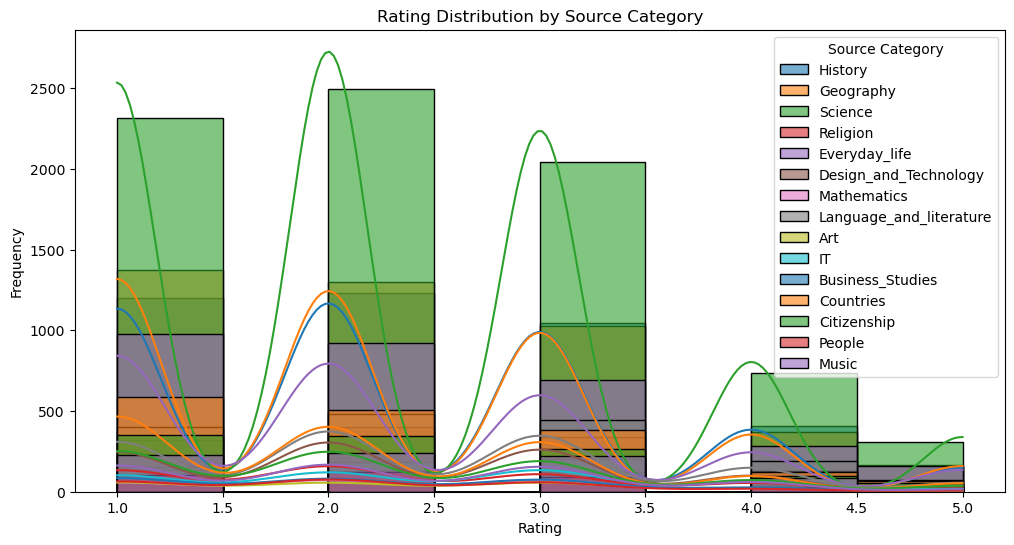

In [ ]:
plt.figure(figsize=(12, 6))

# Loop through each category to plot its distribution separately
for category in df_rating['source_category'].unique():
    subset = df_rating[df_rating['source_category'] == category]
    sns.histplot(subset['rating'], kde=True, label=category, binwidth=0.5, alpha=0.6)

plt.legend(title="Source Category")
plt.title("Rating Distribution by Source Category")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

c:\Users\beaiz\Anaconda3\envs\ML_EPFL\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


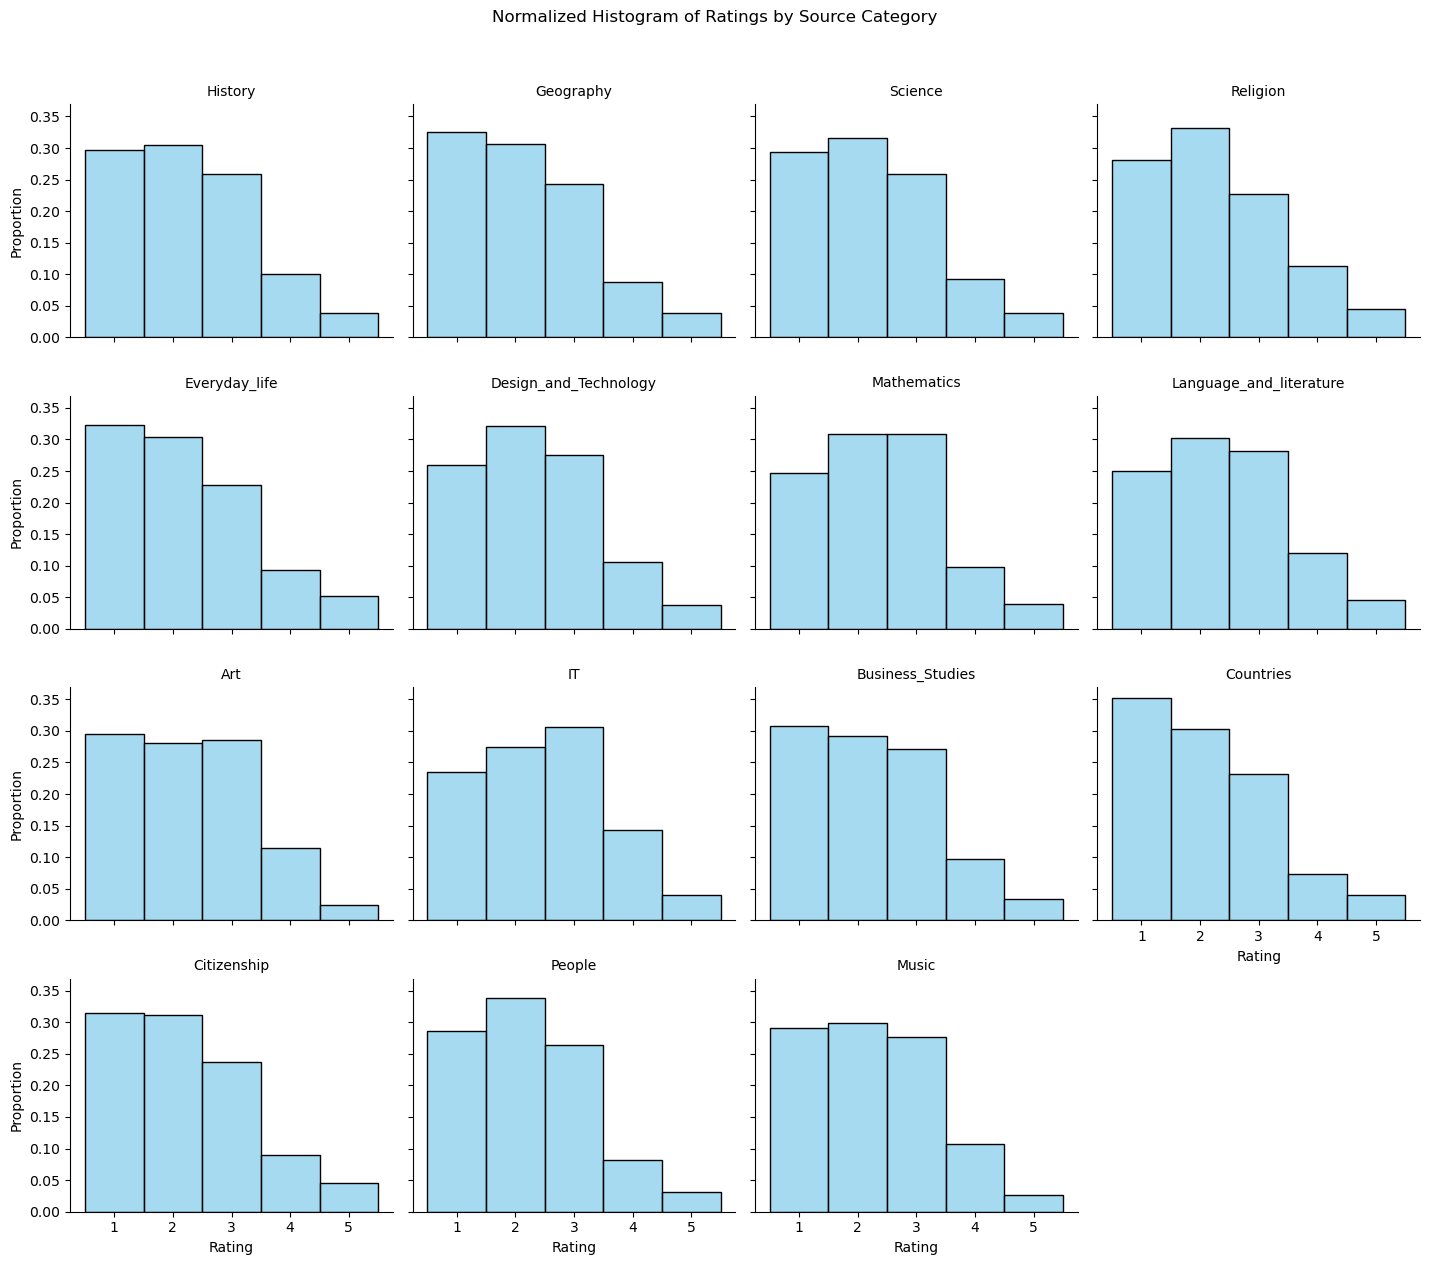

In [ ]:
g = sns.FacetGrid(df_rating, col="source_category", col_wrap=4, height=3, aspect=1.2)
g.map(sns.histplot, "rating", discrete=True, stat="probability", binwidth=1, color='skyblue')
g.set_titles("{col_name}")
g.set_axis_labels("Rating", "Proportion")
g.fig.suptitle("Normalized Histogram of Ratings by Source Category", y=1.05)
plt.show()

In [ ]:
df_rating = df_finished_categories[['rating','source_category']]
df_rating.groupby('source_category')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
source_category,,,,,,,,
Art,332.0,2.292169,1.083604,1.0,1.0,2.0,3.0,5.0
Business_Studies,443.0,2.259594,1.098278,1.0,1.0,2.0,3.0,5.0
Citizenship,1107.0,2.241192,1.127737,1.0,1.0,2.0,3.0,5.0
Countries,1661.0,2.146297,1.101874,1.0,1.0,2.0,3.0,5.0
Design_and_Technology,1244.0,2.341640,1.089629,1.0,1.0,2.0,3.0,5.0
Everyday_life,3040.0,2.249013,1.153631,1.0,1.0,2.0,3.0,5.0
Geography,4238.0,2.210005,1.106879,1.0,1.0,2.0,3.0,5.0
History,4038.0,2.279842,1.108860,1.0,1.0,2.0,3.0,5.0
IT,662.0,2.481873,1.118732,1.0,2.0,2.0,3.0,5.0


-----------------------------------------------------------

In [ ]:
# There are articles that dont have category
# There are NaNs in quitting category
df_quitting_categories = df_unfinished.merge(
    df_categories[['article', 'category1']], 
    left_on='quitting_article', 
    right_on='article',
    how='left'
).rename(columns={'category1': 'quitting_category'}).drop(columns='article')
# Check for which rows:
# Pikachu: does not appear in categories.tsv -> Add same category as other entry related to  Pokèmon -> subject.Everyday_life.Games

nan_rows = df_quitting_categories[df_quitting_categories['quitting_category'].isna()]
print("There are rows with NaN in quitting_category:")
print(f" Proportion of NaN values: {len(nan_rows)/len(df_quitting_categories)*100:.2f} %")


There are rows with NaN in quitting_category:
 Proportion of NaN values: 8.93 %


In [ ]:
# There are no  NaNs in source category
df_source_categories = df_unfinished.merge(
    df_categories[['article', 'category1']], 
    left_on='source', 
    right_on='article',
    how='left'
).rename(columns={'category1': 'source_category'}).drop(columns='article')
# Check for which rows:
# Pikachu: does not appear in categories.tsv -> Add same category as other entry related to  Pokèmon -> subject.Everyday_life.Games

nan_rows = df_source_categories[df_source_categories['source_category'].isna()]
print("There are no rows with NaN in source_category:")
print(f" Proportion of NaN values: {len(nan_rows)/len(df_source_categories)*100:.2f} %")

There are no rows with NaN in source_category:
 Proportion of NaN values: 0.00 %


In [ ]:
# There are NaNs in target category
df_target_categories = df_unfinished.merge(
    df_categories[['article', 'category1']], 
    left_on='target', 
    right_on='article',
    how='left'
).rename(columns={'category1': 'target_category'}).drop(columns='article')
# Check for which rows:
# Pikachu: does not appear in categories.tsv -> Add same category as other entry related to  Pokèmon -> subject.Everyday_life.Games

nan_rows = df_target_categories[df_target_categories['target_category'].isna()]
print("There are rows with NaN in target_category:")
print(f" Proportion of NaN values: {len(nan_rows)/len(df_target_categories)*100:.2f} %")

There are rows with NaN in target_category:
 Proportion of NaN values: 0.11 %


In [ ]:
df_source_categories.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type,source,quitting_article,source_category
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,Obi-Wan_Kenobi,Obi-Wan_Kenobi,Everyday_life
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,Julius_Caesar,Julius_Caesar,History
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,Malawi,Alexander_the_Great,Countries
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,Paraguay,Paraguay,Countries
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,Paraguay,Bolivia,Countries


In [ ]:
source_categories

0          History
1          History
2          History
3          History
4          History
           ...    
51313      History
51314      History
51315      History
51316    Geography
51317      History
Name: source_category, Length: 51318, dtype: object

### Correlation for source, article at which game was abandoned and target with quitting (both behaviours)

In [ ]:
# Create a contingency table with counts of unfinished and finished games by hour
contingency_table = pd.DataFrame({
    'unfinished': df_unfinished_hour,
    'finished': df_finished_hour
})

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print("Chi-Square Test p-value:", p_value)
# Decision to reject/accept null hypothesis
hypothesis_testing(p_value=p_value)

Chi-Square Test p-value: 0.11295098260118867
Given p value = 0.11295098260118867 is greater than alpha = 0.05, the null hypothesis fails to be rejected.


In [ ]:
# Calculate Spearman correlation
hours = df_unfinished_hour.index  # hours (0-23)
unfinished_proprotion_hour = df_unfinished_hour.values  # normalized counts

correlation, p_value = spearmanr(hours, unfinished_proprotion_hour)
print("Spearman Correlation:", correlation)
print("p-value:", p_value)

Spearman Correlation: 0.33963905999680727
p-value: 0.10442947663388846


In [ ]:
df_unfinished.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type,datetime,hour
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,2011-02-07 05:02:15,5
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,2011-02-07 05:14:11,5
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,2011-02-07 15:00:19,15
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,2011-02-07 17:18:25,17
5,131600803df4895e,1297100557,2009,Agriculture;History_of_the_world;China;Yangtze...,Grand_Canal_of_China,timeout,2011-02-07 17:42:37,17
